## 1. Import Packages

In [1]:
import os
import cv2
import glob
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import models, layers
from tensorflow.keras import Input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import plot_model
from PIL import ImageFont, ImageDraw, Image
%matplotlib inline

## 2. GPU Available and Device Check

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11949493593799495483
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 440139776
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1371743290435030251
physical_device_desc: "device: 0, name: NVIDIA Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5"
]


## 3. Dataset
  - DeepFashion (Category and Attribute Prediction Benchmark)
    - http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion/AttributePrediction.html

In [3]:
# # Deepfashion Dataset Path
# orig_dataset_path = '/data/Deepfashion/prepare_dataset'
# orig_train_path = orig_dataset_path + '/train'
# orig_validation_path = orig_dataset_path + '/validation'
# orig_test_path = orig_dataset_path + '/test'

## 4. Category Selection (Train, Validation, Test)
- Deepfashion Attribute and Prediction 원본 데이터 셋 카테고리
    - [('Dress', 52137), ('Tee', 26652), ('Blouse', 17751), ('Shorts', 14194), ('Tank', 11203), ('Skirt', 10793), ('Cardigan', 9605), ('Sweater', 9516), ('Jacket', 7547), ('Top', 7269), ('Romper', 5424), ('Blazer', 5407), ('Jeans', 5125), ('Jumpsuit', 4463), ('Leggings', 3570), ('Joggers', 3259), ('Sweatpants', 2223), ('Kimono', 1636), ('Coat', 1538), ('Cutoffs', 1176), ('Sweatshorts', 780), ('Poncho', 578), ('Jersey', 533), ('Henley', 520), ('Parka', 490), ('Jeggings', 442), ('Chinos', 373), ('Culottes', 358), ('Trunks', 286), ('Button-Down', 242), ('Bomber', 228), ('Flannel', 223), ('Anorak', 120), ('Robe', 106), ('Turtleneck', 98), ('Kaftan', 97), ('Peacoat', 62), ('Capris', 56), ('Onesie', 46), ('Caftan', 37), ('Gauchos', 34), ('Jodhpurs', 31), ('Sarong', 17), ('Coverup', 12), ('Halter', 10)]
- 삭제할 카테고리
    - Halter, Coverup, Sarong, Jodhpurs, Gauchos, Caftan, Onesie, Capris, Kaftan, Turtleneck, Robe, Culottes, Jersey, Poncho, Kimono, Tank, Top, Trunks
- 카테고리 통합
    - Shirt = Button-Down + Flannel
    - Sweatpants = Sweatpants + Sweatshorts
    - Jumpsuit-Romper = Jumpsuit + Romper
    - Jeans = Jeans + Jeggings
    - Blouse-Shirts = Blouse + Shirts
- 카테고리 삭제 및 통합 후
    - ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']

In [4]:
# # Data Load

# # Train
# orig_train = ImageDataGenerator(
#     rescale=1./255
# )

# orig_train_dataset = orig_train.flow_from_directory(
#     orig_train_path,
#     target_size=(224, 224),
#     class_mode='categorical',
#     shuffle=False
# )

# # Validation
# orig_validation = ImageDataGenerator(
#     rescale=1./255
# )

# orig_validation_dataset = orig_validation.flow_from_directory(
#     orig_validation_path,
#     target_size=(224, 224),
#     class_mode='categorical',
#     shuffle=False
# )

# # Test
# orig_test = ImageDataGenerator(
#     rescale=1./255
# )

# orig_test_dataset = orig_test.flow_from_directory(
#     orig_test_path,
#     target_size=(224, 224),
#     class_mode='categorical',
#     shuffle=False
# )

In [5]:
# X_train, y_train = next(orig_train_dataset)

# print(X_train.shape)
# print(y_train.shape)

# X_val, y_val = next(orig_validation_dataset)

# print(X_val.shape)
# print(y_val.shape)

# X_test, y_test = next(orig_test_dataset)

# print(X_test.shape)
# print(y_test.shape)

## 5. Train Origin Dataset Visualization

In [6]:
# orig_train_dataset_class_indices = orig_train_dataset.class_indices
# print('Class indices of orig train dataset: ', orig_train_dataset_class_indices)
# print()
# print(orig_train_dataset_class_indices.keys())

# orig_train_category_nums = {}

# for filename in orig_train_dataset.filenames:
#     train_class_name = filename.split('/')[0]
#     if train_class_name not in orig_train_category_nums:
#         orig_train_category_nums[train_class_name] = 0
#     else:
#         orig_train_category_nums[train_class_name] += 1

# print()
# print("Sorted category nums of orig train dataset: ", sorted(orig_train_category_nums.items(), key=lambda x: x[1], reverse=True))
# print()
# print("Total train dataset nums: ", sum(orig_train_category_nums.values()))
# print()
# fig, ax = plt.subplots()
# plt.bar(list(orig_train_category_nums.keys()), orig_train_category_nums.values())
# plt.title("Class Distribution of Origin Train dataset")
# plt.xticks(rotation=90)
# plt.tick_params(axis='x', width=5, labelsize=8)
# plt.grid(True)
# plt.show()

## 6. Train Dataset Over/Under-sampling and Visualization

In [7]:
# # Train data sampling
# train_class_names = ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
# print(len(train_class_names))

# train_paths = []

# for cls in train_class_names:
#     for f in glob.glob(orig_train_path + '/' + cls + '/*.jpg'):
#         # Undersampling (~10000)
#         if cls == 'Dress' or cls == 'Tee' or cls == 'Blouse-Shirts' or cls == 'Shorts':
#             train_paths.append(f)
#         # 원본 데이터 개수 유지
#         elif cls == 'Skirt' or cls == 'Jumpsuit-Romper' or cls == 'Cardigan' or cls == 'Sweater':
#             train_paths.append(f)
#         # Oversampling 후 10000개로 축소
#         elif cls == 'Jacket':
#             for i in range(2):
#                 train_paths.append(f)
#         # Oversampling
#         elif cls == 'Jeans' or cls == 'Blazer':
#             for i in range(2):
#                 train_paths.append(f)
#         elif cls == 'Leggings'or cls == 'Joggers' or cls == 'Sweatpants' or cls == 'Hoodie':
#             for i in range(3):
#                 train_paths.append(f)
#         elif cls == 'Coat':
#             for i in range(6):
#                 train_paths.append(f)
#         elif cls == 'Cutoffs':
#             for i in range(8):
#                 train_paths.append(f)
#         elif cls == 'Parka':
#             for i in range(16):
#                 train_paths.append(f)
#         elif cls == 'Cottonpants':
#             for i in range(27):
#                 train_paths.append(f)

# print(train_paths[0])
# print(len(train_paths))

# train_paths_class = []

# for cls in train_class_names:
#     for f in glob.glob(orig_train_path + '/' + cls + '/*.jpg'):
#         # Undersampling (~10000)
#         if cls == 'Dress' or cls == 'Tee' or cls == 'Blouse-Shirts' or cls == 'Shorts':
#             train_paths_class.append(f.split('/')[5])
#         # 원본 데이터 개수 유지
#         elif cls == 'Skirt' or cls == 'Jumpsuit-Romper' or cls == 'Cardigan' or cls == 'Sweater':
#             train_paths_class.append(f.split('/')[5])
#         # Oversampling 후 10000개로 축소
#         elif cls == 'Jacket':
#             for i in range(2):
#                 train_paths_class.append(f.split('/')[5])
#         # Oversampling
#         elif cls == 'Jeans' or cls == 'Blazer':
#             for i in range(2):
#                 train_paths_class.append(f.split('/')[5])
#         elif cls == 'Leggings'or cls == 'Joggers' or cls == 'Sweatpants' or cls == 'Hoodie':
#             for i in range(3):
#                 train_paths_class.append(f.split('/')[5])
#         elif cls == 'Coat':
#             for i in range(6):
#                 train_paths_class.append(f.split('/')[5])
#         elif cls == 'Cutoffs':
#             for i in range(8):
#                 train_paths_class.append(f.split('/')[5])
#         elif cls == 'Parka':
#             for i in range(16):
#                 train_paths_class.append(f.split('/')[5])
#         elif cls == 'Cottonpants':
#             for i in range(27):
#                 train_paths_class.append(f.split('/')[5])

# print(train_paths_class[0])
# print(len(train_paths_class))

# train_df = {'filepath': train_paths, 'class_name': train_paths_class}
# df_train = pd.DataFrame(train_df)
# print(df_train)

# train_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finaltrain.csv'
# df_train.to_csv(train_csv_path)

In [8]:
train_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finaltrain2.csv'
train_df = pd.read_csv(train_csv_path)
train_df.head()

,Unnamed: 0,filepath,class_name
0,8816,/data/Deepfashion/prepare_dataset/train/Blazer...,Blazer
1,8817,/data/Deepfashion/prepare_dataset/train/Blazer...,Blazer
2,8818,/data/Deepfashion/prepare_dataset/train/Blazer...,Blazer
3,8819,/data/Deepfashion/prepare_dataset/train/Blazer...,Blazer
4,8820,/data/Deepfashion/prepare_dataset/train/Blazer...,Blazer


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32
)

Found 38001 validated image filenames belonging to 19 classes.


In [10]:
train_category_nums = {}

print(train_generator.filenames[0].split('/')[5])

for filename in train_generator.filenames:
    class_name = filename.split('/')[5]
    if class_name not in train_category_nums:
        train_category_nums[class_name] = 0
    else:
        train_category_nums[class_name] += 1

print(sorted(train_category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(train_category_nums.values()))

Blazer
[('Jumpsuit-Romper', 2000), ('Blazer', 1999), ('Blouse-Shirts', 1999), ('Cardigan', 1999), ('Coat', 1999), ('Cottonpants', 1999), ('Cutoffs', 1999), ('Dress', 1999), ('Hoodie', 1999), ('Jacket', 1999), ('Jeans', 1999), ('Joggers', 1999), ('Leggings', 1999), ('Parka', 1999), ('Shorts', 1999), ('Skirt', 1999), ('Sweater', 1999), ('Sweatpants', 1999), ('Tee', 1999)]
37982


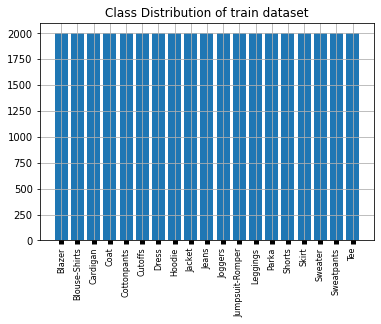

In [11]:
fig, ax = plt.subplots()
plt.bar(list(train_category_nums.keys()), train_category_nums.values())
plt.title("Class Distribution of train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

## 7. Validation Origin Dataset Visualization

In [12]:
# orig_validation_dataset_class_indices = orig_validation_dataset.class_indices
# print('Class indices of orig validation dataset: ', orig_validation_dataset_class_indices)

# orig_validation_category_nums = {}

# for filename in orig_validation_dataset.filenames:
#     validation_class_name = filename.split('/')[0]
#     if validation_class_name not in orig_validation_category_nums:
#         orig_validation_category_nums[validation_class_name] = 0
#     else:
#         orig_validation_category_nums[validation_class_name] += 1

# print()
# print("Sorted category nums of orig validation dataset: ", sorted(orig_validation_category_nums.items(), key=lambda x: x[1], reverse=True))
# print()
# print("Total validation dataset nums: ", sum(orig_validation_category_nums.values()))
# print()
# fig, ax = plt.subplots()
# plt.bar(list(orig_validation_category_nums.keys()), orig_validation_category_nums.values())
# plt.title("Class Distribution of origin validation dataset")
# plt.xticks(rotation=90)
# plt.tick_params(axis='x', width=5, labelsize=8)
# plt.grid(True)
# plt.show()

In [13]:
# # validation data sampling
# validation_class_names = ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
# print(len(validation_class_names))

# validation_paths = []

# for cls in validation_class_names:
#     for f in glob.glob(orig_validation_path + '/' + cls + '/*.jpg'):
#         validation_paths.append(f)

# print(validation_paths[0])
# print(len(validation_paths))

# validation_paths_class = []

# for cls in validation_class_names:
#     for f in glob.glob(orig_validation_path + '/' + cls + '/*.jpg'):
#         validation_paths_class.append(f.split('/')[5])

# print(validation_paths_class[0])
# print(len(validation_paths_class))

# validation_df = {'filepath': validation_paths, 'class_name': validation_paths_class}
# df_validation = pd.DataFrame(validation_df)
# print(df_validation)

# validation_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finalvalidation.csv'
# df_validation.to_csv(validation_csv_path)

In [14]:
validation_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finalvalidation2.csv'
validation_df = pd.read_csv(validation_csv_path)
validation_df.head()

,Unnamed: 0,filepath,class_name
0,840,/data/Deepfashion/prepare_dataset/validation/B...,Blazer
1,841,/data/Deepfashion/prepare_dataset/validation/B...,Blazer
2,842,/data/Deepfashion/prepare_dataset/validation/B...,Blazer
3,843,/data/Deepfashion/prepare_dataset/validation/B...,Blazer
4,844,/data/Deepfashion/prepare_dataset/validation/B...,Blazer


In [15]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 3597 validated image filenames belonging to 19 classes.


In [16]:
validation_category_nums = {}

print(validation_generator.filenames[0].split('/')[5])

for filename in validation_generator.filenames:
    class_name = filename.split('/')[5]
    if class_name not in validation_category_nums:
        validation_category_nums[class_name] = 0
    else:
        validation_category_nums[class_name] += 1

print(sorted(validation_category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(validation_category_nums.values()))

Blazer
[('Jumpsuit-Romper', 202), ('Blazer', 199), ('Blouse-Shirts', 199), ('Cardigan', 199), ('Coat', 199), ('Cutoffs', 199), ('Dress', 199), ('Hoodie', 199), ('Jacket', 199), ('Jeans', 199), ('Joggers', 199), ('Leggings', 199), ('Shorts', 199), ('Skirt', 199), ('Sweater', 199), ('Sweatpants', 199), ('Tee', 199), ('Parka', 113), ('Cottonpants', 79)]
3578


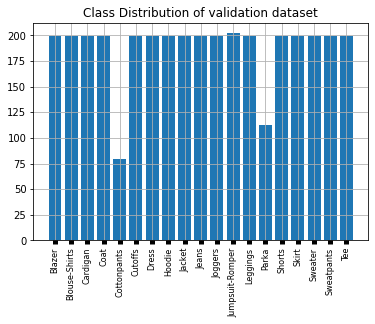

In [17]:
fig, ax = plt.subplots()
plt.bar(list(validation_category_nums.keys()), validation_category_nums.values())
plt.title("Class Distribution of validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

## 8. Test Origin Dataset Visualization

In [18]:
# orig_test_dataset_class_indices = orig_test_dataset.class_indices
# print('Class indices of orig test dataset: ', orig_test_dataset_class_indices)

# orig_test_category_nums = {}

# for filename in orig_test_dataset.filenames:
#     test_class_name = filename.split('/')[0]
#     if test_class_name not in orig_test_category_nums:
#         orig_test_category_nums[test_class_name] = 0
#     else:
#         orig_test_category_nums[test_class_name] += 1

# print()
# print("Sorted category nums of orig test dataset: ", sorted(orig_test_category_nums.items(), key=lambda x: x[1], reverse=True))
# print()
# print("Total test dataset nums: ", sum(orig_test_category_nums.values()))
# print()
# fig, ax = plt.subplots()
# plt.bar(list(orig_test_category_nums.keys()), orig_test_category_nums.values())
# plt.title("Class Distribution of origin test dataset")
# plt.xticks(rotation=90)
# plt.tick_params(axis='x', width=5, labelsize=8)
# plt.grid(True)
# plt.show()

In [19]:
# # test data sampling
# test_class_names = ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
# print(len(test_class_names))

# test_paths = []

# for cls in test_class_names:
#     for f in glob.glob(orig_test_path + '/' + cls + '/*.jpg'):
#         test_paths.append(f)
# print(test_paths[0])
# print(len(test_paths))

# test_paths_class = []

# for cls in test_class_names:
#     for f in glob.glob(orig_test_path + '/' + cls + '/*.jpg'):
#         test_paths_class.append(f.split('/')[5])

# print(test_paths_class[0])
# print(len(test_paths_class))

# test_df = {'filepath': test_paths, 'class_name': test_paths_class}
# df_test = pd.DataFrame(test_df)
# print(df_test)

# test_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finaltest.csv'
# df_test.to_csv(test_csv_path)

In [20]:
test_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finaltest2.csv'
test_df = pd.read_csv(test_csv_path)
test_df.head()

,Unnamed: 0,filepath,class_name
0,847,/data/Deepfashion/prepare_dataset/test/Blazer/...,Blazer
1,848,/data/Deepfashion/prepare_dataset/test/Blazer/...,Blazer
2,849,/data/Deepfashion/prepare_dataset/test/Blazer/...,Blazer
3,850,/data/Deepfashion/prepare_dataset/test/Blazer/...,Blazer
4,851,/data/Deepfashion/prepare_dataset/test/Blazer/...,Blazer


In [21]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 3583 validated image filenames belonging to 19 classes.


In [22]:
test_category_nums = {}

print(test_generator.filenames[0].split('/')[5])

for filename in test_generator.filenames:
    class_name = filename.split('/')[5]
    if class_name not in test_category_nums:
        test_category_nums[class_name] = 0
    else:
        test_category_nums[class_name] += 1

print(sorted(test_category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(test_category_nums.values()))

Blazer
[('Blazer', 199), ('Blouse-Shirts', 199), ('Cardigan', 199), ('Coat', 199), ('Cutoffs', 199), ('Dress', 199), ('Hoodie', 199), ('Jacket', 199), ('Jeans', 199), ('Joggers', 199), ('Jumpsuit-Romper', 199), ('Leggings', 199), ('Shorts', 199), ('Skirt', 199), ('Sweater', 199), ('Sweatpants', 199), ('Tee', 199), ('Parka', 109), ('Cottonpants', 72)]
3564


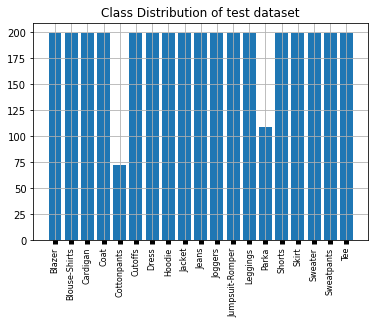

In [23]:
fig, ax = plt.subplots()
plt.bar(list(test_category_nums.keys()), test_category_nums.values())
plt.title("Class Distribution of test dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

## 9. Summary

In [27]:
train_class_labels_sampling = list(train_generator.class_indices.keys())
validation_class_labels_sampling = list(validation_generator.class_indices.keys())
test_class_labels_sampling = list(test_generator.class_indices.keys())
print('Sampling train class labels: \n', train_class_labels_sampling)
print('The number of train class labels: ', len(train_class_labels_sampling))
print('The number of train images sampling: ', len(train_generator.filenames))
print()
print('Sampling validation class labels: \n', validation_class_labels_sampling)
print('The number of validation class labels: ', len(validation_class_labels_sampling))
print('The number of validation images sampling: ', len(validation_generator.filenames))
print()
print('Sampling test class labels: \n', test_class_labels_sampling)
print('The number of test class labels: ', len(test_class_labels_sampling))
print('The number of test images sampling: ', len(test_generator.filenames))
print()


Sampling train class labels: 
 ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
The number of train class labels:  19
The number of train images sampling:  38001

Sampling validation class labels: 
 ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
The number of validation class labels:  19
The number of validation images sampling:  3597

Sampling test class labels: 
 ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
The number of test class labels:  19
The number of test images sampling:  3583



## 10. ResNet50 Model Building

In [25]:
# number of classes
K = 19

# input tensor
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')

In [26]:
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   

def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x

def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x

def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x

def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)

x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)

resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

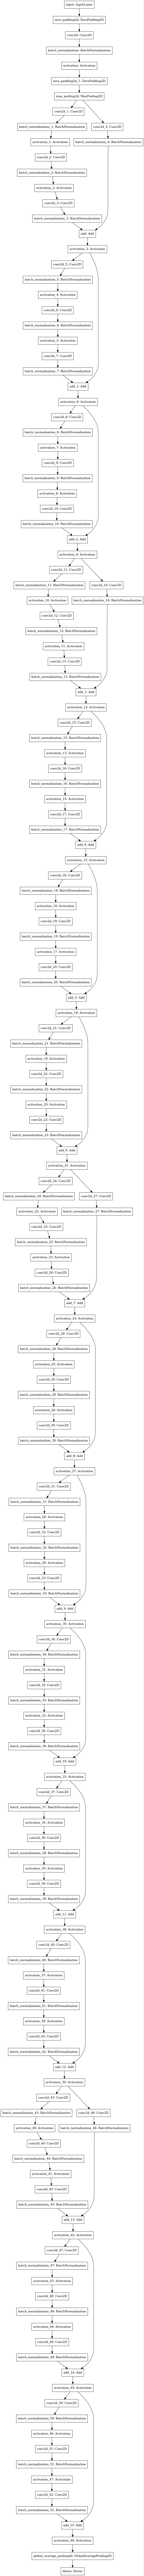

In [28]:
# Show a summary of the model
plot_model(resnet50, to_file='/home/azure/passion/AI/Final/output/model_summary/final2.jpg')

In [32]:
# Compile Model
resnet50.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')
    ]
)

## 11. Plotting Accuracy & Loss Curves

In [33]:
def curves(model_histories, epochs):

    acc = model_histories.history['accuracy']
    top_3_categorical_accuracy = model_histories.history['top_3_categorical_accuracy']
    top_5_categorical_accuracy = model_histories.history['top_5_categorical_accuracy']
    val_acc = model_histories.history['val_accuracy']
    val_top_3_categorical_accuracy = model_histories.history['val_top_3_categorical_accuracy']
    val_top_5_categorical_accuracy = model_histories.history['val_top_5_categorical_accuracy']
    loss = model_histories.history['loss']
    val_loss = model_histories.history['val_loss']

    # Plot
    plt.plot(range(epochs), acc, 'mo', label='Training accuracy')
    plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Final/output/plot/final_accuracy2.jpg')

    plt.figure()
    plt.plot(range(epochs), loss, 'mo', label='Training loss')
    plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Final/output/plot/final_loss2.jpg')
    
    plt.figure()
    plt.plot(range(epochs), top_3_categorical_accuracy, 'mo', label='Training top 3 categorical accuracy')
    plt.plot(range(epochs), val_top_3_categorical_accuracy, 'b', label='Validation top 3 categorical accuracy')
    plt.title('Training and validation top 3 catagorical accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Final/output/plot/final_top_3_accuracy2.jpg')
    
    plt.figure()
    plt.plot(range(epochs), top_5_categorical_accuracy, 'mo', label='Training top 5 categorical accuracy')
    plt.plot(range(epochs), val_top_5_categorical_accuracy, 'b', label='Validation top 5 categorical accuracy')
    plt.title('Training and validation top 5 catagorical accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Final/output/plot/final_top_5_accuracy2.jpg')
    plt.show()

## 12. Register Callbacks

In [34]:
def callback():
    
    # CSVLogger
    filename = '/home/azure/passion/AI/Final/output/csv_logger/final2.csv'
    csv_log = tf.keras.callbacks.CSVLogger(
        filename, 
        separator=' ', 
        append=False
    )
    
    # EarlyStopping
#     early_stopping = tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss', 
#         patience=300, 
#         verbose=1, 
#         mode='min'
#     )
    
    # ReduceLRonPlateau
#     lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         patience=20,
#         factor=0.5,
#         verbose=1
#     )
    
    # ModelCheckpoint
    check_point = tf.keras.callbacks.ModelCheckpoint(
        filepath='/home/azure/passion/AI/Final/output/checkpoint/final2.ckpt',
        save_best_only=True, save_weights_only=True, monitor='val_loss'
    )
    
    callback_list = [csv_log, check_point]
    return callback_list

In [35]:
callback_list = callback()

## 13. Fine-tune the model - Training

In [36]:
def fit_model(model, train_generator, validation_generator):
    
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        workers=0,
        verbose=1,
        callbacks=callback_list
    )

    score = model.evaluate(
        validation_generator,
        verbose=1
    )

    return model, history, score

In [ ]:
model, history, score = fit_model(resnet50, train_generator, validation_generator)

# Learning curves
curves(history, 10)
print('Validation Accuracy:{} \nValidation Loss:{}'.format(score[1] ,score[0]))
print('Validation Top 3 Accuracy: ', score[2])
print('Validation Top 5 Accuracy: ', score[3])
print(score)
# Model Save
model.save('/home/azure/passion/AI/Final/output/saved_model/final2.h5')

Epoch 1/10
1123/1188 [===========================>..] - ETA: 1:21 - loss: 2.9011 - accuracy: 0.1205 - top_3_categorical_accuracy: 0.2874 - top_5_categorical_accuracy: 0.4185

## 14. Evaluation

In [10]:
model = tf.keras.models.load_model('/home/azure/passion/AI/Final/output/saved_model/final1.h5')
evaluation = model.evaluate(test_generator)
print('Test Loss: ', evaluation[0])
print('Test Accuracy: ', evaluation[1])
print('Test Top 3 Accuracy: ', evaluation[2])
print('Test Top 5 Accuracy: ', evaluation[3])

555/555 [==============================] - 125s 199ms/step - loss: 14.1995 - accuracy: 0.7173 - top_3_categorical_accuracy: 0.9201 - top_5_categorical_accuracy: 0.9660
Test Loss:  14.199454307556152
Test Accuracy:  0.717322051525116
Test Top 3 Accuracy:  0.9201127290725708
Test Top 5 Accuracy:  0.9660324454307556



## 15. Confusion Matrix & Classification Report

In [12]:
Y_pred = model.predict(test_generator)
Y_pred_argmax = np.argmax(Y_pred, axis=1)
Y_pred_list = Y_pred_argmax.tolist()
print(Y_pred_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 1, 1, 11, 8, 0, 18, 0, 0, 18, 0, 0, 1, 18, 8, 8, 0, 1, 0, 0, 0, 0, 1, 0, 3, 8, 0, 0, 0, 0, 0, 0, 6, 0, 0, 1, 1, 1, 8, 8, 1, 0, 0, 8, 0, 0, 18, 0, 0, 0, 1, 0, 18, 0, 0, 0, 0, 0, 0, 0, 8, 1, 0, 8, 0, 2, 0, 1, 0, 1, 1, 0, 18, 1, 8, 1, 1, 1, 0, 0, 16, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 6, 0, 8, 8, 0, 11, 8, 16, 0, 8, 0, 12, 2, 0, 8, 1, 1, 2, 0, 15, 18, 1, 18, 1, 1, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 18, 0, 0, 0, 0, 0, 6, 0, 8, 0, 2, 0, 1, 0, 8, 0, 0, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 1, 0, 0, 0, 0, 8, 0, 8, 8, 0, 0, 0, 0, 1, 1, 11, 8, 1, 1, 0, 2, 1, 1, 1, 8, 0, 1, 0, 0, 0, 8, 8, 0, 0, 0, 8, 18, 0, 0, 0, 18, 1, 0, 8, 0, 8, 8, 0, 8, 18, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 8, 0, 0, 8, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 2, 0, 0, 0, 0, 14, 1, 8, 0, 8, 0, 0, 11, 8, 8, 0, 0, 8, 0, 0, 1, 0, 0, 1, 0, 0, 0, 11, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

In [13]:
valY_labels = test_generator.labels
print(valY_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [14]:
class_labels_sampling = list(test_generator.class_indices.keys())
print(class_labels_sampling)

['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']


## 16. Confusion Matrix and Classification Report

In [15]:
def confusion_mat(Y_pred_list, valY_labels):
    confusion_mat = confusion_matrix(valY_labels, Y_pred_list)
    plt.figure(figsize=(6, 4))
    df_confusion_mat = pd.DataFrame(confusion_mat)
    sns.heatmap(df_confusion_mat, annot_kws={"size": 5}, linewidths=.5, cmap='PuBu',
               annot=True, yticklabels=class_labels_sampling, xticklabels=class_labels_sampling, fmt='g'
               )
    plt.xticks(rotation=90)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/home/azure/passion/AI/Final/output/plot/final_confusion_matrix1.jpg')
    return plt

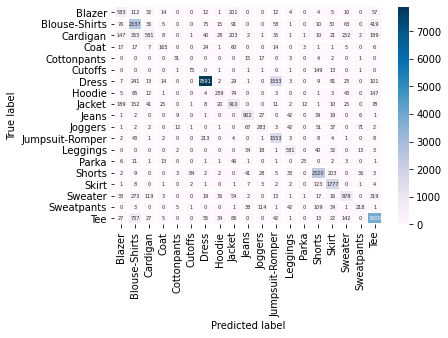

In [16]:
confusion_mat = confusion_mat(Y_pred_list, valY_labels)


In [17]:
classification_rep = classification_report(Y_pred_list, valY_labels, target_names=class_labels_sampling)
print(classification_rep)

                 precision    recall  f1-score   support

         Blazer       0.56      0.53      0.54      1097
  Blouse-Shirts       0.74      0.56      0.64      4567
       Cardigan       0.31      0.67      0.42       872
           Coat       0.51      0.64      0.57       256
    Cottonpants       0.42      0.49      0.46        63
        Cutoffs       0.31      0.45      0.37       165
          Dress       0.79      0.95      0.86      8346
         Hoodie       0.40      0.63      0.49       381
         Jacket       0.61      0.52      0.56      1760
          Jeans       0.86      0.81      0.84      1111
        Joggers       0.49      0.57      0.53       493
Jumpsuit-Romper       0.84      0.47      0.60      3307
       Leggings       0.80      0.76      0.78       762
          Parka       0.21      0.57      0.31        40
         Shorts       0.84      0.80      0.82      2909
          Skirt       0.92      0.77      0.84      2312
        Sweater       0.49    

## 17. Conversion to Tensorflow lite

In [18]:
# Tensorflow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('/home/azure/passion/AI/Final/output/tflite/final1.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpus2i0z9v/assets


102441176